In [1]:
!pip install hdbscan
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 11.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039288 sha256=7b411d49a61adec7a79712ca5e3eec5138d185ae15c68c022aecbf4fa9980564
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.9
    Uninstalling Cython-3.0.9:
      Successfully uninstalled Cython-3.0.9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.0 MB/s eta 0:00:00
  Created wh

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers import BertTokenizer, BertModel
from hdbscan import HDBSCAN

from sklearn import metrics
import umap

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## TF-IDF Vectorization on the Utterance Level

In [4]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000,
                                   min_df=1,
                                   max_df=0.85,
                                   ngram_range=(1, 2))

In [5]:
X_tfidf = tfidf_vectorizer.fit_transform(test['text'])

In [6]:
X_tfidf.shape

(3080, 1000)

In [7]:
tfidf_matrix=X_tfidf.toarray()

## UMAP Dimension Reduction

In [8]:
umap_model = umap.UMAP(n_neighbors=10, n_components=5, metric='cosine')
umap_reduced = umap_model.fit_transform(tfidf_matrix)

## HDBSCAN Clustering with UMAP and TF-IDF on the Utterance Level

In [9]:
hdbscan_model = HDBSCAN(min_cluster_size=15)
clusters = hdbscan_model.fit_predict(umap_reduced)

test['topic'] = clusters

In [10]:
test['topic'].unique()

array([22, -1, 36,  5, 38, 23,  8, 26, 15, 34, 24, 17,  6,  7, 10,  2, 21,
       30, 20, 39, 42, 31, 28, 18, 32, 33, 19, 40, 37, 41,  9, 29,  3, 14,
        4, 12, 25, 13, 11, 16, 27, 35,  0,  1])

<ipython-input-11-3701307bba0e>:8: UserWarning: 
The palette list has fewer values (33) than needed (44) and will cycle, which may produce an uninterpretable plot.
  scatter = sns.scatterplot(x=umap_reduced[:, 0], y=umap_reduced[:, 1],hue=test['topic'],legend='full', alpha=0.8,palette=custom_palette)


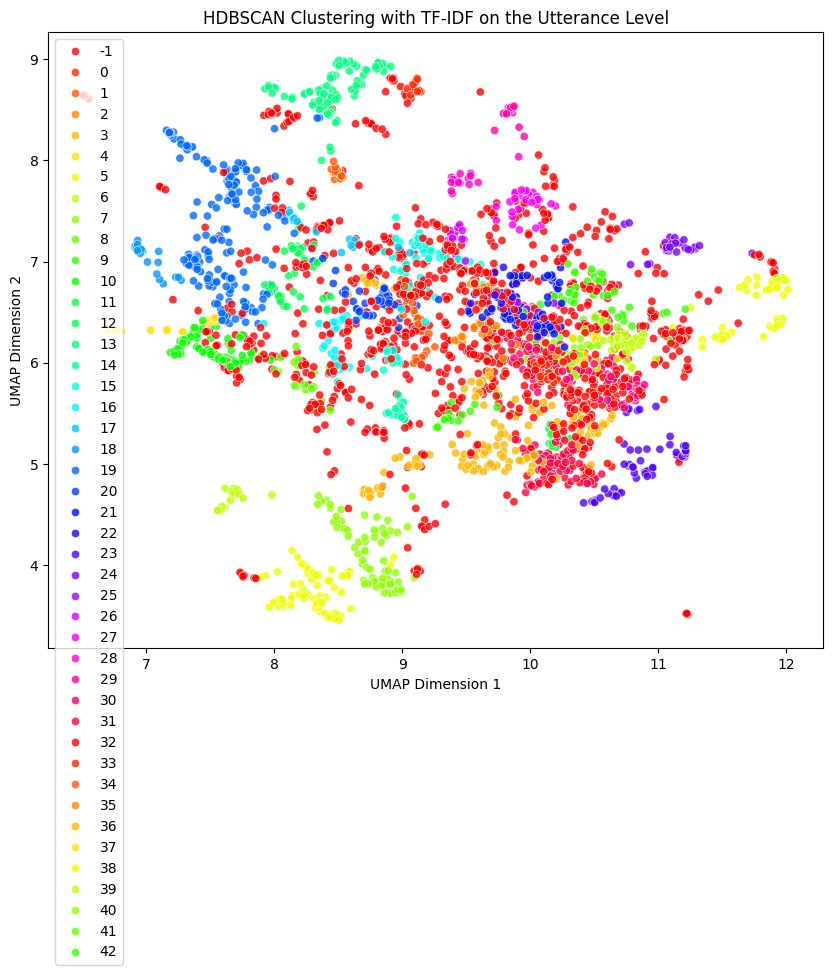

In [11]:
hues = np.linspace(0, 1, 33, endpoint=False)
saturation = 0.9
value = 0.9

custom_palette = [plt.cm.hsv(h) for h in hues]

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x=umap_reduced[:, 0], y=umap_reduced[:, 1],
                          hue=test['topic'], legend='full', alpha=0.8,
                          palette=custom_palette)
plt.title('HDBSCAN Clustering with TF-IDF on the Utterance Level')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()

The points are more densely packed and spread out, which could indicate a lack of clear separation between clusters.

## Bert-Banking Embedding on the Utterance Level

In [12]:
tokenizer = BertTokenizer.from_pretrained('philschmid/BERT-Banking77')
model = BertModel.from_pretrained('philschmid/BERT-Banking77')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/5.95k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [13]:
def get_sentence_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    return embeddings

# Apply the function to each utterance
test['BERT_embeddings'] = test['text'].apply(get_sentence_embeddings)

## UMAP Dimension Reduction

In [14]:
bert_embeddings = np.vstack(test['BERT_embeddings'].to_numpy())
umap_embeddings = umap.UMAP(n_neighbors=10, n_components=5, metric='cosine').fit_transform(bert_embeddings)

## HDBSCAN Clustering with UMAP and Bert-Banking Embedding on the Utterance Level

In [15]:
hdbscan = HDBSCAN(min_cluster_size=18)
test["topic"] = hdbscan.fit_predict(umap_embeddings)

<ipython-input-16-a69b479b524f>:12: UserWarning: 
The palette list has fewer values (25) than needed (79) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=test["topic"], legend='full', alpha=0.8, palette=custom_palette)


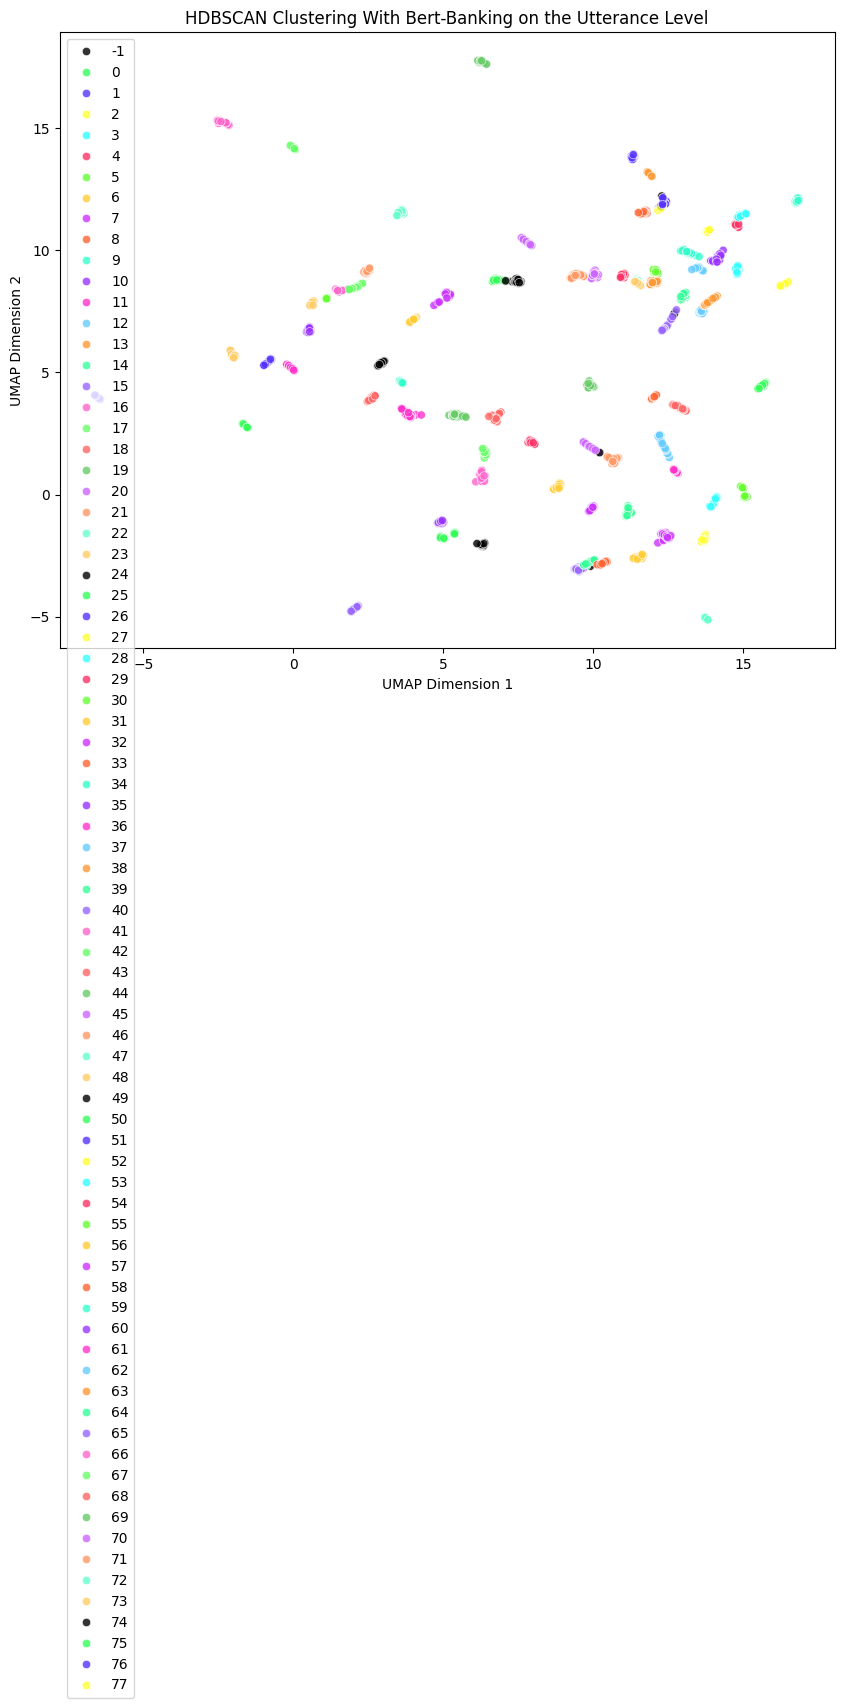

In [16]:
custom_colors = [
    '#000000', '#33FF57', '#5733FF', '#FFFF33', '#33FFFF',
    '#FF3366', '#66FF33', '#FFCC33', '#CC33FF',
    '#FF6633', '#33FFCC', '#9933FF', '#FF33CC', '#66CCFF',
    '#FF9933', '#33FF99', '#9966FF', '#FF66CC', '#66FF66',
    '#FF6666', '#66CC66', '#CC66FF', '#FF9966', '#66FFCC', '#FFCC66'
]

custom_palette = sns.color_palette(custom_colors)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1],
                hue=test["topic"], legend='full', alpha=0.8,
                palette=custom_palette)
plt.title('HDBSCAN Clustering With Bert-Banking on the Utterance Level')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()

The clusters seem well separated, and there is a variety of them.